# Setup

Retrieve "GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv" from [this GitHub link](https://github.com/nasa/GeneLab_Data_Processing/blob/master/scRNAseq/10X_Chromium_3prime_Data/GeneLab_CellType_GeneMarkers/GL-DPPD-7111_GeneMarker_Files/GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv) and save it in the same directory as this notebook. The GitHub path is `nasa/GeneLab_Data_Processing/scRNAseq/10X_Chromium_3prime_Data/GeneLab_CellType_GeneMarkers/GL-DPPD-7111_GeneMarker_Files`.



Possible Map My Cells region keys = ["RHP", "RSP", "ACA", "PL-ILA-ORB", "AUD-TEa-PERI-ECT", "SS-GU-VISC", "MO-FRP", "PAL", "sAMY", "CTXsp", "HY", "STRv", "OLF", "LSX", "AI", "STRd", "VIS-PTLp", "VIS", "TH", "MOp", "ENT", "HIP", "P", "MB", "MY", "CB", "AUD", "SSp", "TEa-PERI-ECT"]

---

**Use Conda**

While in the folder containing this notebook:
`conda env create -f rapidsc.yml`



Navigate back to where you want to clone the `scflow` repository (I recommend home)
`cd`

Clone `scflow` from GitHub.
`git clone git@github.com:easlinger/scflow.git`

Navigate to the folder where `scflow` is:
`pip install .`

`pip install senepy`

---

**For NVIDIA Drivers (Linux)**

```
sudo apt update
sudo apt install -y build-essential dkms

sudo apt install -y wget
wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
sudo mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/3bf863cc.pub
sudo add-apt-repository "deb https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/ /"

sudo apt update
sudo apt install -y cuda
```

---


## Imports & Display

In [ ]:
%load_ext autoreload
%autoreload 2
%xmode plain

import os
import re
import logging
import json
try:
    import torch
    torch.set_float32_matmul_precision("medium")
except Exception:
    pass
# try:
#     import rapids_singlecell as rsc
# except Exception:
#     rsc = None
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import scflow

pd.set_option("display.max_rows", 500)  # or None for unlimited rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 200)


class CategoricalFilter(logging.Filter):
    def filter(self, record):
        return "storing" not in record.getMessage() or \
               "as categorical" not in record.getMessage()


logger = logging.getLogger("anndata")
logger.addFilter(CategoricalFilter())

Exception reporting mode: Plain


/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/jaxopt/__init__.py:59: DeprecationWarning: JAXopt is no longer maintained. See https://docs.jax.dev/en/latest/ for alternatives.
  warnings.warn(
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/__init__.py:17: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  __version_info__ = tuple(LooseVersion(__version__).version)
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/marshmallow/fields.py:198: RemovedInMarshmallow4Warning: Passing field metadata as a keyword arg is deprecated. Use the explicit `metadata=...` argument instead.
  warnings.warn(
/home/easlinger/miniconda3/envs/rsc/lib/python3.13/site-packages/pkg_resources/__init__.py:3146: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('sphinxcontrib')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_nam

## Set Options (ACTIVELY SET THESE!)

In [2]:
# Processors to Use
n_processors = os.cpu_count() - 1  # how many processors to use

# If You Want Results Emailed
cur_file = os.path.join(os.path.abspath(""), "create_object_612.ipynb")
html_out = os.path.splitext(cur_file)[0] + ".html"
email = "elizabeth.aslinger@aya.yale.edu"
# set email to None to skip

# Set Data Sources & Species
species = "Mouse"
batches = ["OSD-612"]  # in list even if just 1, or list multiple to integrate

# Set Source Data Directory & Output Options
superdirec = "/home/easlinger/data"  # directory with original data
direcs = [os.path.join(superdirec, i) for i in batches]
# new h5ad will write to "data" sub-directory of where this notebook is
overwrite = True  # allow overwrite of files?
file_concat = os.path.join("data", f"{'_'.join(batches)}_concatenated.h5ad")
file_new = os.path.join("data", f"{'_'.join(batches)}_integrated.h5ad")

# Set Sample & Batch IDs, Plus Other Potential Sources of Batch Effects
col_group = "Group"  # age &/or space flight
col_age = "Characteristics[Age at Euthanasia]"
# col_age = "Factor Value[Age]"
col_condition = "Factor Value[Spaceflight]"
col_sample = "sample"
col_batch = "batch" if len(batches) > 1 else col_group  # group=batch if 1
# covariates_categorical = ["Comment[Euthanasia Date]"]
# covariates_continuous = ["Time"]
covariates_categorical = None
covariates_continuous = None

# Do Sub-Clustering?
# subcluster_biggest = 1  # sub-cluster biggest cluster
# subcluster_biggest = 3  # sub-cluster biggest 3 clusters
subcluster_biggest = False  # no sub-clustering
kws_cluster = dict(n_comps=50)  # cluster individual samples
# kws_cluster = None  # do not cluster individual samples
# vars_regress_out = ["Time", "pct_counts_mt",
#                     "total_counts"]  # to regress out of concatenated object
vars_regress_out = None

# Set Annotation Sources
map_my_cells_source = "WMB-10X" if species == "Mouse" else "WHB-10X" if (
    species == "Human") else None  # Map My Cells atlas source
# map_my_cells_region_keys = None
map_my_cells_region_keys = [
    "RSP", "ACA", "PL-ILA-ORB", "AUD-TEa-PERI-ECT", "SS-GU-VISC", "MO-FRP",
    "AI", "VIS-PTLp", "VIS", "MOp", "AUD", "SSp",
    "TEa-PERI-ECT"]  # regional subset for Map My Cells
map_my_cells_cell_keys = ["Isocortex"]  # pattern match: feature name column
if species == "Mouse":
    model_celltypist = "Mouse_Whole_Brain.pkl"
else:
    raise ValueError("Manually set CellTypist model for non-mouse!")
source_patterns = ["Brain", "Cortical", "cortex"]  # for ToppGene

# Make Pre-Defined Marker Dictionary
cts_superhierarchical = {
    "Neuron": ["Excitatory", "Inhibitory", "Glutamatergic", "GABAergic",
               "Dopaminergic", "Serotonergic", "Cholinergic"]
}  # if classified as Neuron + other, just keep more specific type(s)
rename_marker_based_annotation = {
    "Excitatory | Inhibitory": "Excitatory-Inhibitory",
    "Inhibitory | Inhibitory": "Excitatory-Inhibitory"
}
mks_a_priori = pd.read_csv("GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv")
mks_a_priori.loc[:, "cellName"] = mks_a_priori.cellName.replace({
    "Oligodendrocyte precursor cell": "OPC"}).apply(
        lambda x: " ".join([i.capitalize() for i in re.sub(
            " cell", "", x).split(" ")])).replace({
                "Opc": "OPC"})  # capitalize cell names
mks_a_priori = mks_a_priori.set_index("cellName")["geneSymbol"]
mks_a_priori = dict(mks_a_priori.apply(lambda x: set(x.split(","))))
mks_a_priori.update({
    "Neuroepithelial": {"Nes", "Notch1", "Sox2", "Sox10", "Hes1", "Hes3"},
    "Excitatory": {"Slc17a7", "Slc30a3", "Tcf4",
                   "Slc17a6", "Slc6a1", "Baiap3",
                   "Grin1", "Grin2b", "Gls"},
    "Inhibitory": {"Gad1", "Slc6a1", "Gabbr1", "Gabbr2",
                   "Gad2", "Slc32a1", "Oprm1", "Htr2c"},
    # "Glutamatergic": {"Slc17a7", "Slc17a6", "Grin1", "Grin2b", "Gls"},
    # "GABAergic": {"Slc6a1", "Gabbr1", "Gabbr2", "Gad2", "Gad1"},
    # "Dopaminergic": {"Th", "Dat", "Foxa2", "Girk2", "Nurr1", "Lmx1b"},
    # "Serotonergic": {"Tph", "Sert", "Pet1"},
    # "Cholinergic": {"ChAT", "VAChT", "Acetylcholinesterase"}
})
markers_predefined = {**mks_a_priori}
if cts_superhierarchical is not None:
    for i in cts_superhierarchical:
        for k in [u for u in cts_superhierarchical[
                i] if u in markers_predefined]:
            markers_predefined[k] = markers_predefined[k].union(
                markers_predefined[i])
    _ = [markers_predefined.pop(i) for i in cts_superhierarchical]
mks_collapsed = {**mks_a_priori}
mks_collapsed["Neuron"] = mks_collapsed["Neuron"].union(mks_collapsed[
    "Excitatory"]).union(mks_collapsed["Inhibitory"])
_ = mks_collapsed.pop("Excitatory")
_ = mks_collapsed.pop("Inhibitory")

## Load Individual Sample Data

In [4]:
%%time

# Create a Subdirectory of Working Directory for Data Outputs
os.makedirs("data", exist_ok=True)

# Get Metadata
metadata = [pd.read_csv(os.path.join(
    superdirec, f"{i}_metadata_{i}-ISA/s_{i}.txt"), sep=None,
                        engine="python").set_index("Source Name").rename_axis(
                            col_sample) for i in batches]  # list of metadata
for u in np.arange(len(metadata)):  # add a combined age & condition variable
    metadata[u] = metadata[u].join(metadata[u].apply(
        lambda x: x[col_condition] + str(
            " | " + str(x[col_age]) + " Weeks" if (
                col_age in metadata[u].columns and len(
                    metadata[u][col_age].unique()) > 1) else ""),
        axis=1).to_frame(col_group))  # add space flight (x age if applicable)

# Load Data
adatas, files = {}, {}
for u, d in enumerate(direcs):  # iterate directories, then samples within
    for x in [i for i in os.listdir(d) if os.path.isdir(os.path.join(d, i))]:
        ddd = [os.path.join(d, x, i) for i in os.listdir(os.path.join(d, x))]
        if len(ddd) > 1:  # ensure 1 subdirectory (for the sample) in folder
            raise ValueError(f"More than one file: {ddd}")
        sample = os.path.basename(os.path.join(d, x, ddd[0]))  # sample ID
        files[sample] = os.path.join(os.path.join(d, x, ddd[0]),
                                     "filtered_feature_bc_matrix.h5")  # file
        adatas[sample] = sc.read_10x_h5(files[sample])  # read anndata (h5)
        if col_batch:  # if a batch column specified
            adatas[sample].obs.loc[:, col_batch] = batches[u]  # batch => .obs
        adatas[sample].obs.loc[:, col_sample] = sample  # sample ID => .obs
        samp_metadata = metadata[u].loc[sample] if (
            sample in metadata[u].index.values) else metadata[u].set_index(
                "Sample Name").loc[sample]  # extract sample-specific metadata
        for v in samp_metadata.index.values:  # loop metadata => .obs columns
            adatas[sample].obs.loc[:, v] = samp_metadata.loc[v]
        adatas[sample].obs.loc[:, f"n_cells_original_{col_sample}"] = adatas[
            sample].obs.shape[0]  # original number of cells
print(files)
metadata

{'RR10_BRN_GC_WT_G5': '/home/easlinger/data/OSD-612/RR10_BRN_GC_WT_G5-20250307T234232Z-001/RR10_BRN_GC_WT_G5/filtered_feature_bc_matrix.h5', 'RR10_BRN_FLT_WT_F1': '/home/easlinger/data/OSD-612/RR10_BRN_FLT_WT_F1-20250307T231611Z-001/RR10_BRN_FLT_WT_F1/filtered_feature_bc_matrix.h5', 'RR10_BRN_GC_WT_G1': '/home/easlinger/data/OSD-612/RR10_BRN_GC_WT_G1-20250307T210200Z-001/RR10_BRN_GC_WT_G1/filtered_feature_bc_matrix.h5', 'RR10_BRN_GC_WT_G9': '/home/easlinger/data/OSD-612/RR10_BRN_GC_WT_G9-20250307T234621Z-001/RR10_BRN_GC_WT_G9/filtered_feature_bc_matrix.h5', 'RR10_BRN_FLT_WT_F3': '/home/easlinger/data/OSD-612/RR10_BRN_FLT_WT_F3-20250307T205407Z-001/RR10_BRN_FLT_WT_F3/filtered_feature_bc_matrix.h5', 'RR10_BRN_GC_WT_G3': '/home/easlinger/data/OSD-612/RR10_BRN_GC_WT_G3-20250307T235702Z-001/RR10_BRN_GC_WT_G3/filtered_feature_bc_matrix.h5', 'RR10_BRN_FLT_WT_F7': '/home/easlinger/data/OSD-612/RR10_BRN_FLT_WT_F7-20250307T235407Z-001/RR10_BRN_FLT_WT_F7/filtered_feature_bc_matrix.h5', 'RR10_BRN_

[                    Sample Name Characteristics[Organism] Term Source REF                              Term Accession Number Characteristics[Strain] Term Source REF.1 Term Accession Number.1  \
 sample                                                                                                                                                                                           
 RR-10_FL-01  RR10_BRN_FLT_WT_F1              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...              B6129SF2/J               OSD  https://osdr.nasa.gov/   
 RR-10_FL-03  RR10_BRN_FLT_WT_F3              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...              B6129SF2/J               OSD  https://osdr.nasa.gov/   
 RR-10_FL-05  RR10_BRN_FLT_WT_F5              Mus musculus       NCBITAXON  http://purl.bioontology.org/ontology/NCBITAXON...              B6129SF2/J               OSD  https://osdr.nasa.gov/   
 RR-10_FL-07  RR10_BRN_FL

# QC

## Perform Sample-Specific QC

In [12]:
descriptives.stack().unstack("Variable")["pct_counts_mt"].loc[:, :, "75%", :]

sample              Group         
RR10_BRN_FLT_WT_F1  Space Flight      0.969078
RR10_BRN_FLT_WT_F3  Space Flight      4.331071
RR10_BRN_FLT_WT_F5  Space Flight      1.673758
RR10_BRN_FLT_WT_F7  Space Flight      2.403296
RR10_BRN_FLT_WT_F9  Space Flight      2.887328
RR10_BRN_GC_WT_G1   Ground Control    2.141680
RR10_BRN_GC_WT_G3   Ground Control    2.867505
RR10_BRN_GC_WT_G5   Ground Control    2.283085
RR10_BRN_GC_WT_G7   Ground Control    2.069467
RR10_BRN_GC_WT_G9   Ground Control    3.091378
Name: pct_counts_mt, dtype: float64

Variable                                  n_cells_by_counts  n_genes_by_counts  pct_counts_mt  total_counts
sample             Group          Metric                                                                   
RR10_BRN_FLT_WT_F1 Space Flight   count             56748.0            11879.0        11879.0       11879.0
                                  mean                398.0             1900.0            1.0        4298.0
                                  std                1096.0             1096.0            1.0        3711.0
                                  min                   0.0               44.0            0.0          48.0
                                  2.5%                  0.0              395.0            0.0         523.0
                                  10%                   0.0              540.0            0.0         761.0
                                  25%                   0.0              892.0            0.0        1387.0
                                  50%                   4.0             1917.0            0.0        3680.0
                                  75%                 153.0             2593.0            1.0        5865.0
                                  85%                 625.0             3003.0            1.0        7406.0
                                  90%                1195.0             3306.0            2.0        8687.0
                                  97.5%              3985.0             4238.0            5.0       13230.0
                                  max               11876.0            11082.0           25.0       93231.0
RR10_BRN_FLT_WT_F3 Space Flight   count             56748.0            12875.0        12875.0       12875.0
                                  mean                384.0             1692.0            4.0        3583.0
                                  std                1086.0              986.0            5.0        3186.0
                                  min                   0.0                9.0            0.0           9.0
                                  2.5%                  0.0              362.0            0.0         488.0
                                  10%                   0.0              532.0            0.0         783.0
                                  25%                   0.0              966.0            1.0        1546.0
                                  50%                   4.0             1576.0            2.0        2850.0
                                  75%                 144.0             2158.0            4.0        4414.0
                                  85%                 600.0             2629.0            7.0        5865.0
                                  90%                1128.0             2976.0           10.0        7074.0
                                  97.5%              3794.0             4068.0           20.0       12019.0
                                  max               12866.0             9150.0           47.0       46452.0
RR10_BRN_FLT_WT_F5 Space Flight   count             56748.0             3307.0         3307.0        3307.0
                                  mean                 94.0             1620.0            2.0        3400.0
                                  std                 264.0              960.0            2.0        2795.0
                                  min                   0.0               64.0            0.0          98.0
                                  2.5%                  0.0              313.0            0.0         423.0
                                  10%                   0.0              429.0            0.0         601.0
                                  25%                   0.0              678.0            0.0        1017.0
                                  50%                   1.0             1694.0            1.0        3107.0
                                  75%                  36.0             2235.0            2.0        4674.0
    

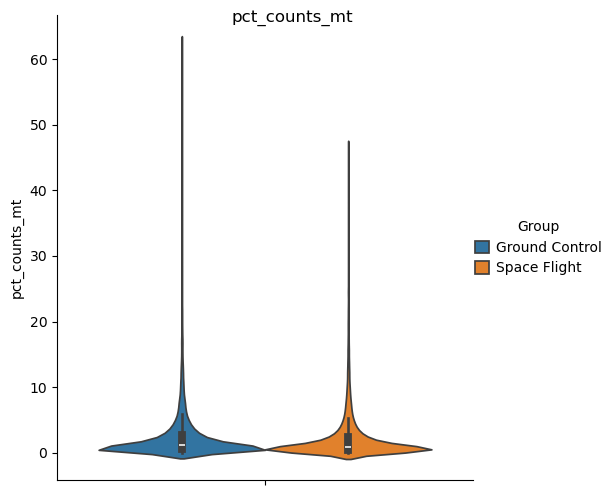

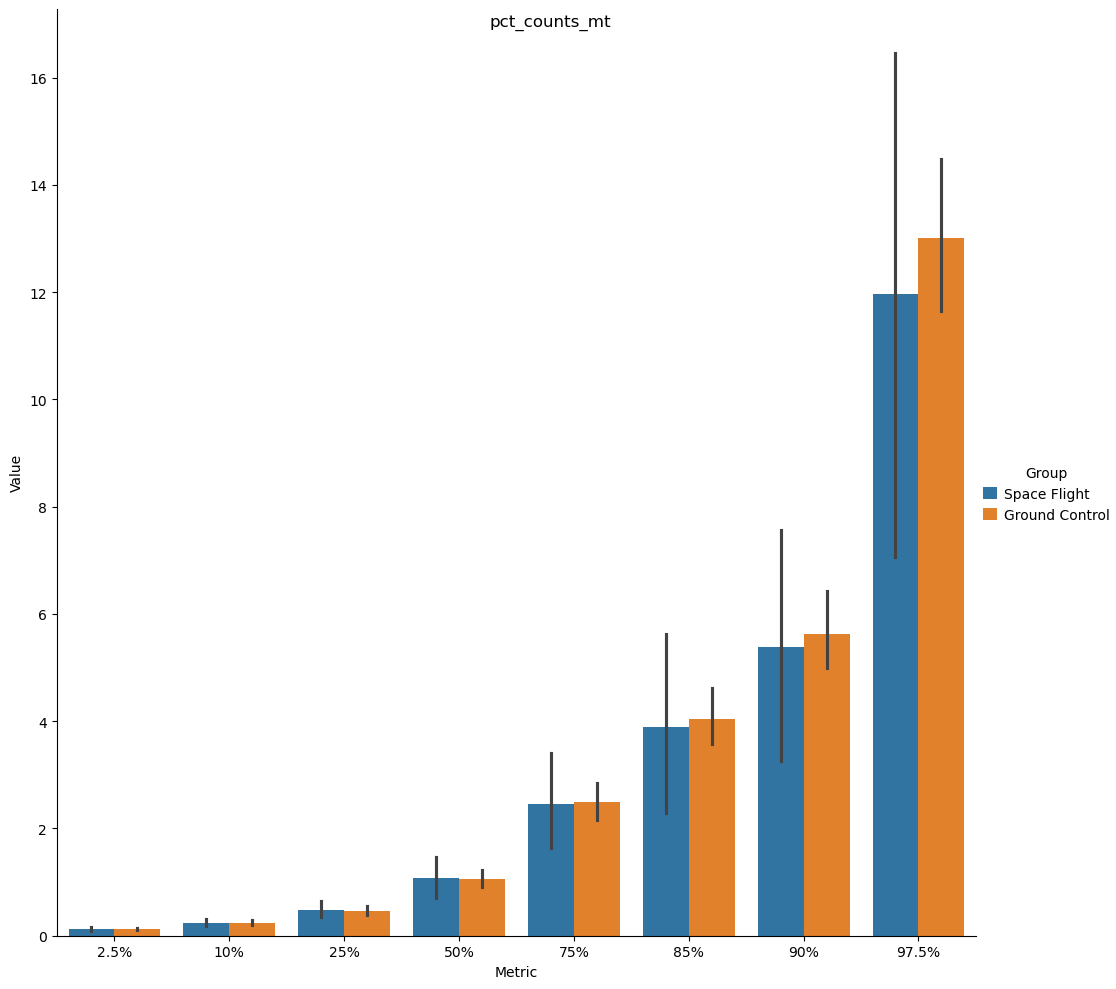

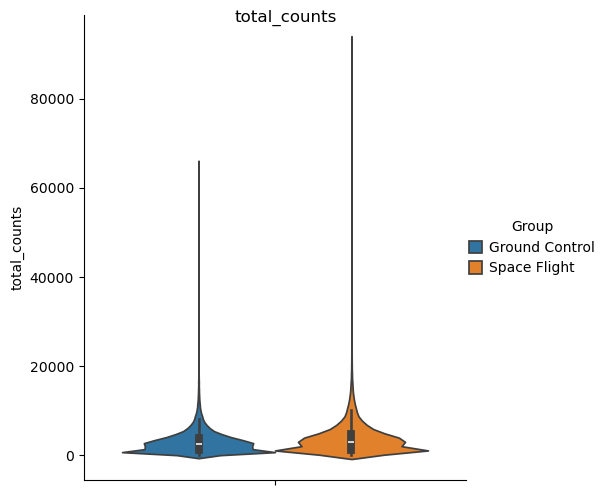

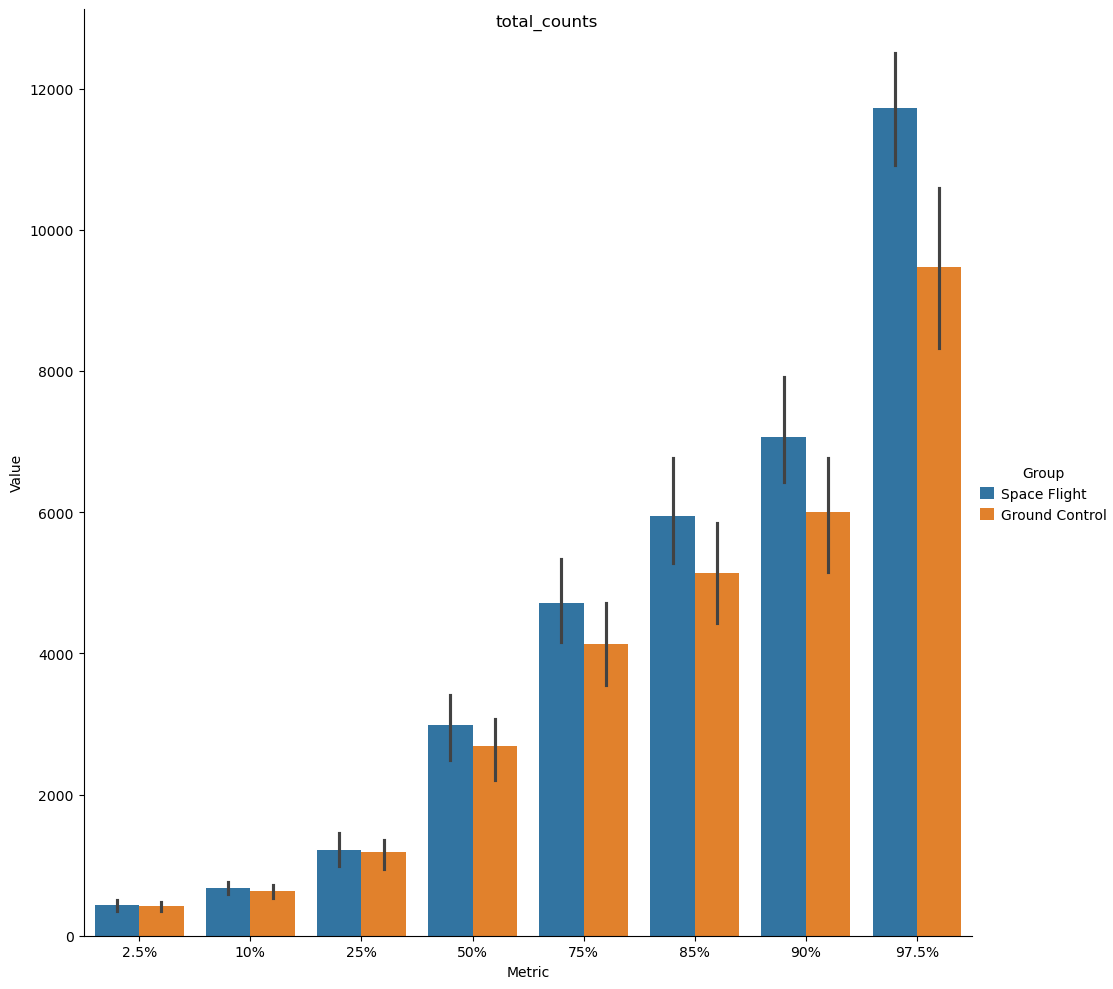

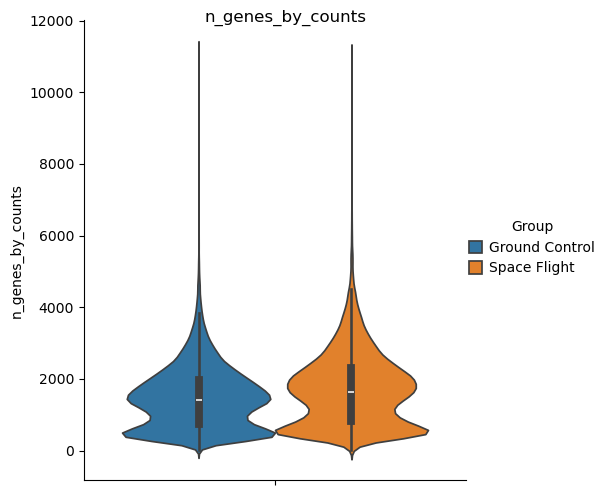

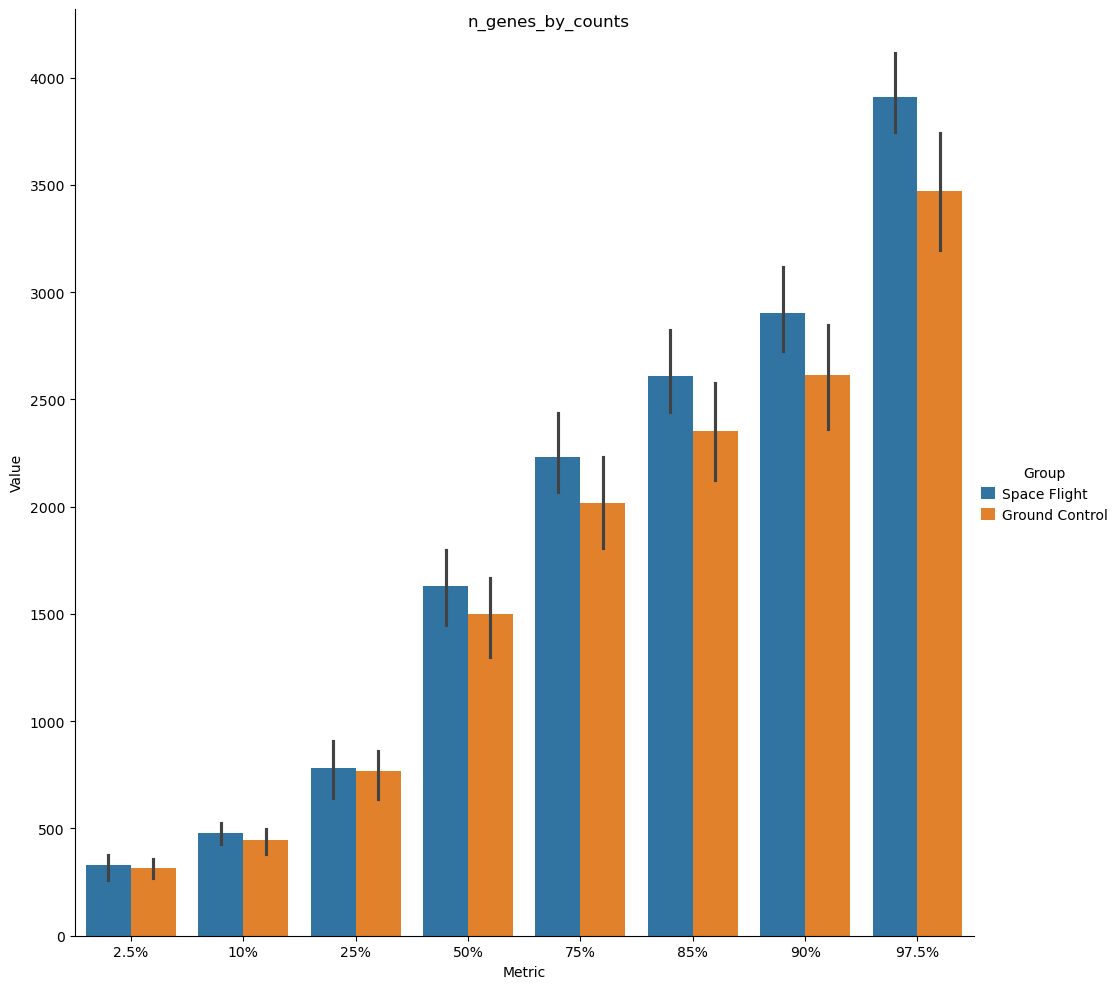

In [5]:
%matplotlib inline

plot_qc = False  # change to True to get sample-level QC plots (a bit slow)
qcs, n_cells_by_counts, descriptives, figs = scflow.pp.perform_qc_multi(
    adatas, col_batch=col_batch, col_sample=col_sample, plot=plot_qc,
    percentiles=[0.025, 0.10, 0.25, 0.50, 0.75, 0.85, 0.90, 0.975],
    figsize=(10, 10))  # perform QC on individual samples
for x in qcs:  # iterate QC metrics % plot percentiles by group
    fig = sns.catplot(qcs, y=x, hue=col_batch, kind="violin")
    fig.fig.suptitle(x)
    fig = sns.catplot(descriptives.loc[:, :, x][[
        i for i in descriptives if ("%" in i)]].stack().to_frame("Value"),
                      x="Metric", y="Value", kind="bar",
                      hue=col_batch, height=10)
    fig.fig.suptitle(x)
descriptives.stack().unstack("Variable").round()

## Auto-Detect Filtering Thresholds

Use 2.5th and/& 97.5th percentile (sample-specific) as minimum genes per cell and minimum and maximum total counts (subject to specified absolute minima). Use 97.5th percentile as upper bound for percent mitochondrial count. 

Use an absolute minimum cells per gene.

Also include arguments to run a PCA on individual samples before integrating.

In [ ]:
# Options
bounds = descriptives[["2.5%", "97.5%"]].apply(lambda x: list(
    x), axis=1).unstack("Variable")  # list top/bottom 5% (~sample, variable)
abs_min_cells = 20  # regardless of %ile, minimum cells to retain gene
abs_min_genes = 200  # regardless of %ile, minimum genes to retain cell
abs_min_count = 300  # regardless of %ile, minimum counts to retain cell
abs_max_mt = 10  # regardless of %ile, absolute maximum mitochonrial content
n_top_genes = 2000  # number of top genes to count as HVGs

# Set Thresholds
kws_pp = {}
for x in adatas:
    b_x = bounds.loc[x]
    b_counts =  b_x["total_counts"] if isinstance(b_x[
            "total_counts"], list) else b_x["total_counts"].iloc[0]
    b_counts = [max(b_counts[0], abs_min_count), b_counts[1]]
    kws_pp[x] = {
        "min_max_genes": [max((b_x["n_genes_by_counts"] if isinstance(
            b_x["n_genes_by_counts"], list) else b_x[
                "n_genes_by_counts"].iloc[0])[0], abs_min_genes), None],
        "min_max_cells": [abs_min_cells, None],
        # "min_max_cells": [max((b_x["n_cells_by_counts"] if isinstance(
        #     b_x["n_genes_by_counts"], list) else b_x[
        #         "n_genes_by_counts"].iloc[0])[0], abs_min_cells), None],
        # "max_mt": min(abs_max_mt, (b_x["pct_counts_mt"] if isinstance(b_x[
        #     "pct_counts_mt"], list) else b_x["pct_counts_mt"].iloc[0])[1]),
        "max_mt": abs_max_mt,
        "min_max_counts": b_counts,
        # "vars_regress_out": ["total_counts"],
        "target_sum": 1e4,
        "zero_center": True, "max_value": 10,  # scaling
        "n_top_genes": n_top_genes,
        "doublet_detection": "drop"
    }
print("\n".join([f"{s}: {kws_pp[s]}" for s in kws_pp]))
pd.DataFrame(kws_pp).T

# Integrate

## In-Memory Approach

See the "On-Disk Approach" for a more sophisticated approach to defining `kws_integrate` (more options).

In [ ]:
# %%time

# # Integrate
# join_method = "outer"  # or "inner"
# kws_integrate = {"kws_pp": kws_pp, "n_top_genes": 10000,
#                  "fill_value": np.nan,
#                  "col_batch": None,  # suppress using batch as covariate
#                  "join": join_method, "merge": "unique", "use_rapids": True}
# self = scflow.Rna(adatas, col_sample=col_sample, col_batch=col_batch,
#                   kws_integrate=kws_integrate)
# self.rna.obs = self.rna.obs.assign(kws_integrate=str(kws_integrate))

# # Write Files for Processed/Integrated Objects?
# if overwrite is True or not os.path.exists(file_new):
#     os.makedirs("data", exist_ok=True)
#     self.rna.write_h5ad(file_new)
# for x in adatas:
#     pfp = os.path.join("data", f"{x}_processed.h5ad")
#     if overwrite is True or not os.path.exists(pfp):
#         adatas[x].write_h5ad(pfp)
# del adatas  # to save memory; now integrated in `self.rna`

# # Display
# print(self.rna)
# # print(self.rna.var.head())
# self.rna.obs

## On-Disk Approach

### Preprocess Individual

#### Filter & Normalize

In [ ]:
# Preprocess
if overwrite is False and os.path.exists(pfp):
    raise ValueError("Must be able to overwrite to use on-disk option")
files_individual = dict(zip(files.keys(), [os.path.join(
    "data", f"{x}_processed.h5ad") for x in files]))  # new individual files
var_names = []  # to store genes not filtered out for each sample
for x in files:  # iterate sample files
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    adatas[x].obs.loc[:, f"kws_pp_{col_sample}"] = str(kws_pp[x])  # store kws
    adatas[x] = scflow.pp.preprocess(
        adatas[x], **kws_pp[x], plot_qc=False)  # preprocess data
    var_names += [set(adatas[x].var_names)]  # track what genes still present

# Decide Join Method
shared_genes = set.intersection(*var_names)  # genes in all after filtering
all_genes = set.union(*var_names)  # genes in any post-filter sample
print(f"{len(shared_genes)} genes present in all samples post-filtering (out"
      f" of {len(all_genes)} total genes present in any post-filter sample)")
join_method = "inner" if len(shared_genes) / len(all_genes) >= 0.5 else \
    "outer"  # outer join if <1/2 of genes shared across all samples

#### Test Preprocessing

Unit tests

In [ ]:
for p, ann in zip([kws_pp[x] for x in kws_pp], [adatas[x] for x in adatas]):
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n")
    if join_method == "inner":
        assert all(ann.var["n_cells_by_counts"] >= p["min_max_cells"][0])
        assert all(ann.var["n_cells_by_counts"] <= p[
            x]["min_max_cells"][1]) if kws_pp[x]["min_max_cells"][1] else True
    assert all(ann.obs["n_genes_by_counts"] >= p["min_max_genes"][0])
    assert all(ann.obs["n_genes_by_counts"] <= p[
        "min_max_genes"][1]) if p["min_max_genes"][1] else True
    assert all(ann.obs["pct_counts_mt"] <= p["max_mt"])
    assert all(ann.obs["total_counts"] >= p["min_max_counts"][0])
    assert all(ann.obs["total_counts"] <= p["min_max_counts"][1]) if (
        p["min_max_counts"][1]) else True
    print(p)
    print(ann.obs[["n_genes", "pct_counts_mt", "total_counts"]
                  ].describe().loc[["min", "max"]])
    print(ann.var[["n_cells_by_counts"]].describe().loc[[
        "min", "max"]])

### Cluster Individual

#### *A Priori* Clustering Parameters

In [ ]:
# %%time

# # Clustering Parameter Options (Only Applied If `kws_cluster` != None)
# resolution_individual, min_dist_individual = 0.15, 1.5
# col_cluster_individual = "annotation_by_markers_individual"
# unlabeled_cat = "Heterogeneous"  # if can't find one best-fit cell label
# cci_scanvi = col_cluster_individual + "_heterogeneous_collapsed"
# sep = " | "  # separator for heterogeneous annotations

# # Preprocessing & (Optionally) Clustering
# if overwrite is False and os.path.exists(pfp):
#     raise ValueError("Must be able to overwrite to use on-disk option")
# # del adatas
# for x in files:  # iterate sample files
#     if kws_cluster is not None:  # cluster individual sample?
#         kws_cl = {"resolution": resolution_individual[x],
#                   "min_dist": min_dist_individual[x], **kws_cluster}
#         self.rna.obs.loc[:, "kws_cluster_individual"] = str(kws_cl)
#         adatas[x] = scflow.pp.cluster(
#             adatas[x], resolution=resolution_individual,
#             min_dist=min_dist_individual, plot=False,
#             col_celltype="leiden_individual", **kws_cl)  # cluster
#         sc.tl.rank_genes_groups(
#             adatas[x], "leiden_individual", n_genes=None, rankby_abs=False,
#             key_added="rank_genes_groups_leiden_individual",
#             copy=False)  # find markers/DEGs
#         if markers_predefined is not None:  # markers specified?
#             _, adatas[x] = scflow.pp.annotate_by_marker_overlap(
#                 adatas[x], markers_predefined,
#                 col_celltype="leiden_individual",
#                 col_celltype_new=col_cluster_individual, sep=sep,
#                 celltypes_superhierarchical=cts_superhierarchical,
#                 # top_n_markers=20,
#                 adj_pval_threshold=1e-10,
#                 method="overlap_coef", inplace=True)  # annotate by markers
#             if rename_marker_based_annotation is not None:
#                 adatas[x].obs.loc[:, col_cluster_individual] = adatas[
#                     x].obs[col_cluster_individual].replace(
#                         rename_marker_based_annotation)  # re-name
#             adatas[x].obs.loc[:, cci_scanvi] = adatas[x].obs[
#                 col_cluster_individual].apply(lambda x: unlabeled_cat if (
#                     sep in x) else x)  # re-label heterogeneous annotations
#     var_names += [set(adatas[x].var_names)]  # track what genes still there

# # Write Objects
# for x in adatas:
#     print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n{adatas[x]}\n")
#     adatas[x].write_h5ad(files_individual[x])  # write individual file

# # Plot
# if kws_cluster is not None:
#     for x in files:  # iterate sample files
#         ccs = [v for v in ["leiden_individual", col_cluster_individual
#                            ] if v in adatas[x].obs]  # columns for UMAP
#         print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
#         sc.pl.umap(adatas[x], color=ccs, wspace=0.4)  # plot UMAP
# del adatas  # save memory

#### Optimize Hyperparameters

Iterate different clustering parameters to ensure extraction of common cell types

Make sample-specific alterations to one sample's annotation

In [ ]:
# Clustering Parameter Options (Only Applied If `kws_cluster` != None)
req_cts = ["Neuron", "OPC", "Oligodendrocyte", "Astrocyte", "Microglial"]
prohib_cts = ["Excitatory-Inhibitory"]
resn_list = [0.2, 0.5, 0.1, 0.075, 0.15]
dist_list = [1.5, 0.75, 0.5, 1, 0.3]
col_cluster_individual = "annotation_by_markers_individual"
unlabeled_cat = "Heterogeneous"  # if can't find one best-fit cell label
cci_scanvi = col_cluster_individual + "_heterogeneous_collapsed"
sep = " | "  # separator for heterogeneous annotations

# Clustering
for x in files:  # iterate sample files
    valid_cts = False
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}")
    for r in resn_list:
        if valid_cts is True:
            break
        for t in dist_list:
            if valid_cts is True:
                break
            c_i = f"leiden_individual_res{r}dist{t}"
            cai = f"{col_cluster_individual}_res{r}dist{t}"
            kws_cl = {"resolution": r, "min_dist": t, **kws_cluster}
            adatas[x] = scflow.pp.cluster(
                adatas[x], plot=False, col_celltype=c_i, **kws_cl)
            sc.tl.rank_genes_groups(
                adatas[x], c_i, n_genes=None,
                key_added=f"rank_genes_groups_{c_i}",
                copy=False)  # find markers/DEGs
            _, adatas[x] = scflow.pp.annotate_by_marker_overlap(
                adatas[x], mks_collapsed,
                col_celltype=c_i, col_celltype_new=cai, sep=sep,
                celltypes_superhierarchical=cts_superhierarchical,
                # top_n_markers=20,
                adj_pval_threshold=1e-15,
                method="overlap_count", inplace=True)  # annotate
            if rename_marker_based_annotation is not None:
                adatas[x].obs.loc[:, cai] = adatas[x].obs[cai].replace(
                        rename_marker_based_annotation)  # re-name
            print(list(adatas[x].obs[cai].unique()))
            adatas[x].obs.loc[:, cci_scanvi] = adatas[x].obs[
                cai].apply(lambda x: unlabeled_cat if (sep in x) else x)
            valid_cts = all([q in adatas[x].obs[cai].unique()
                             for q in req_cts])
            valid_cts = valid_cts and (all([q not in adatas[x].obs[
                cai].unique() for q in prohib_cts]))
            valid_cts = False if any(adatas[x].obs[
                cci_scanvi] == unlabeled_cat) else valid_cts
            if valid_cts is True:
                adatas[x].obs.loc[:, "leiden_individual"] = adatas[x].obs[c_i]
                adatas[x].obs.loc[:, col_cluster_individual] = adatas[
                    x].obs[cai]
                adatas[x].obs.loc[:, "kws_cluster_individual"] = str(kws_cl)
                print(kws_cl)

# Detect Samples with No Valid Clustering Scheme
no_valid = []
for x in files:
    if all((i in adatas[x].obs for i in [
            "leiden_individual", col_cluster_individual])) is False:
        print(f"No valid clustering found for {x}")
        no_valid += [x]
print(f"No Valid Clustering Scheme Yet: {no_valid}")

# # Individual Tweak
# samp = "RRRM2_BRN_GC_ISS-T_YNG_GY4"
# cols_tries = [i for i in adatas[samp].obs if "leiden_" in i]
# cts_try = cols_tries[14]
# _, adatas[samp] = scflow.pp.annotate_by_marker_overlap(
#     adatas[samp], mks_collapsed, col_celltype=cts_try,
#     col_celltype_new=col_cluster_individual + "_new", sep=sep,
#     adj_pval_threshold=1e-5,
#     method="overlap_coef", inplace=True)  # annotate by markers
# adatas[samp].obs.loc[:, "leiden_individual"] = adatas[samp].obs[cts_try]
# adatas[samp].obs.loc[:, col_cluster_individual] = adatas[samp].obs[
#     col_cluster_individual + "_new"]
# adatas[samp].obs["kws_cluster_individual"] = str({"resolution": float(
#     cts_try.split("res")[1].split("dist")[0]), "min_dist": float(
#         cts_try.split("res")[1].split("dist")[1])})

# Write Objects
for x in adatas:
    print(f"\n\n{'=' * 80}\n{x}\n{'=' * 80}\n\n{adatas[x]}\n")
    adatas[x].write_h5ad(files_individual[x])  # write individual file

# Print Parameters Used
for x in adatas:
    print(adatas[x].obs["kws_cluster_individual"])

# Plot
for x in adatas:
    sc.pl.pca_variance_ratio(adatas[x], log=True)
    sc.pl.umap(adatas[x], color=[
        "leiden_individual", col_cluster_individual], wspace=0.4)
del adatas

### Concatenate & Integrate

If you are concerned about hard drive space, you may want to delete `file_concat` and `files_individual` after running this cell.

In [ ]:
%%time

# Integration Options
cct_available = kws_cluster is not None and (
    markers_predefined is not None)  # individual annotations available?
kws_vi = {"early_stopping": True,
          "batch_size": 1024,  # raise/lower if more/less than 16 GB VRAM
          "max_epochs": 100,
          "accelerator": "gpu",
          "categorical_covariate_keys": covariates_categorical,
          "continuous_covariate_keys": covariates_continuous,
          "n_latent": 40, "n_hidden": 400}  # scVI/scANVI arguments
if covariates_categorical is not None:
    print(metadata[0][covariates_categorical + [
        col_group]].value_counts().unstack(col_group).replace(
            np.nan, 0).astype(int))
kws_integrate = {
    "col_celltype": cci_scanvi if cct_available else None,
    "flavor": "scanvi",
    # "flavor": "scvi",
    # "flavor": "scanorama",
    # "flavor": "harmony",
    "kws_pp": None, "kws_cluster": None,
    "vars_regress_out": vars_regress_out,
    "max_value": 10, "zero_center": True, "target_sum": 1e4,
    "n_top_genes": n_top_genes,
    "join": join_method, "merge": "same",
    "col_batch": None,  # suppress using batch as covariate
    "drop_non_hvgs": True,  # just for the integration part
    "use_rapids": True,
    "fill_value": np.nan if join_method == "outer" else None,
    "out_file": file_concat, **kws_vi
}

# If scVI/scANVI Integration & Individual Annotations Available
if kws_integrate["flavor"] in ["scvi", "scanvi"] and cct_available is True:
    kws_integrate.update({"unlabeled_category": unlabeled_cat})

# Integrate & Store Integration Parameters in Object
self = scflow.Rna(files_individual, col_sample=col_sample,
                  col_batch=col_batch, kws_integrate=kws_integrate)
self.rna.obs = self.rna.obs.assign(kws_integrate=str(kws_integrate))

# Write Files for Processed/Integrated Objects?
if overwrite is True or not os.path.exists(file_new):
    self.rna.write_h5ad(file_new)

# Display
print(self.rna)
self.rna.obs

## Benchmark Integration

In [ ]:
# if kws_integrate["flavor"] == "scanvi":
#     try:
#         results_integration_benchmark = scflow.pp.benchmark_integration(
#             self.rna, col_sample, col_celltype="annotation_scanvi")
#     except Exception as err:
#         print(err)

# Clustering

Perform PCA, UMAP embedding, and Leiden clustering on the integrated object

Marker gene-related code looks at top markers by log2fold-change and adjusted p-value cutoffs and sorts by adjusted p-values. Plots for predefined marker expression by cluster (if available) and cluster DEGs are created. Use `kind = ["heat", "dot"]` to get dot plots too.

In [ ]:
%%time

# Clustering Options
resolution, min_dist = 0.0075, 1.8
# resolution, min_dist = 0.015, 1.5
# resolution, min_dist = 0.022, 1.5
# resolution, min_dist = 0.025, 1
# resolution, min_dist = 0.027, 1.3
# resolution, min_dist = 0.012, 1.5
# resolution, min_dist = 0.027, 1.3
# resolution, min_dist = 0.035, 1.3
# resolution, min_dist = 0.02, 0.6
# resolution, min_dist = 0.018, 0.7
# resolution, min_dist = 0.012, 0.5
# resolution, min_dist = 0.0115, 1.5
# resolution, min_dist = 0.011, 0.5
# n_neighbors = 100
# n_neighbors = 20
n_neighbors = 15
cct = "leiden"  # key added/column name

# Set Default Cell Type Column
col_celltype = cct
self._info["col_celltype"] = col_celltype

# Clustering
self.cluster(col_celltype=cct, resolution=resolution, min_dist=min_dist,
             kws_pca=False, layer="scaled",
             kws_neighbors=dict(n_neighbors=n_neighbors))  # cluster
self.rna.obs = self.rna.obs.assign(**{
       f"{cct}_resolution": resolution}).assign(
              **{f"{cct}_n_neighbors": n_neighbors}).assign(
                     **{f"{cct}_min_dist": min_dist})  # store parameters
_ = self.plot(kind="umap", wspace=0.5, palette="tab20",
              color=[col_batch, "leiden", col_sample])  # plot UMAP
print(self.rna.obs["leiden"].value_counts().to_frame("n_cells"))  # N/cluster
print(self.rna.obs.groupby(col_sample).apply(lambda x: x[
       cct].value_counts(), include_groups=False).unstack(1))  # by group

# DEGs (One Cluster versus All)
self.find_markers(col_celltype=cct)  # DEGs by cluster
markers_df = self.get_markers_df(
    n_genes=15, col_celltype=cct,
    p_threshold=1e-10, log2fc_threshold=1.5, log2fc_threshold_abs=False)
markers_dict = dict(markers_df.groupby(cct).apply(
    lambda x: list(x.reset_index().names)))  # dictionary version of df
_ = self.plot(genes=markers_dict, figsize=(15, 15),
              layer="scaled", standard_scale="obs", kind="heat")
if markers_predefined is not None:
    mks_c = dict(zip(markers_predefined, [markers_predefined[x].intersection(
           self.rna.var_names) for x in markers_predefined]))
    mks_c["Inhibitory"] = mks_c["Inhibitory"].difference(mks_c["Excitatory"])
    mks_c["Excitatory"] = mks_c["Excitatory"].difference(mks_c["Inhibitory"])
    _ = self.plot(genes=mks_c, figsize=(15, 15), vmax=0.7,
                  layer="scaled", standard_scale="obs", kind="heat")
markers_df

# Sub-Clustering

Sub-cluster the biggest <subcluster_biggest> Leiden clusters?

For instance if `subcluster_biggest = 3`, take top three most abundant (highest cell count) clusters and sub-cluster them.

In [ ]:
resolution_sub = None if subcluster_biggest is False else 0.005

if subcluster_biggest is not False:

    # Sub-Clustering
    col_celltype = "leiden_subcluster"
    biggest_clusters = self.rna.obs["leiden"].value_counts().index.values[
        :min(len(self.rna.obs["leiden"].unique()), subcluster_biggest)]
    self.rna.obs.loc[:, col_celltype] = self.rna.obs.leiden.copy()
    for x in biggest_clusters:
        sc.tl.leiden(self.rna, restrict_to=(col_celltype, [x]),
                     key_added=col_celltype, resolution=resolution_sub,
                     seed=0, n_iterations=-1, use_weights=True)
    self.find_markers(col_celltype=col_celltype)  # DEGs by cluster
    self.plot(kind="umap", color=col_celltype)
    print(self.rna.obs[[col_sample, col_celltype]].groupby(
        col_sample).value_counts().unstack(1))
    self.rna.obs.loc[:, f"resolution_{col_celltype}"] = resolution_sub
    self._info["col_celltype"] = col_celltype

    # Marker Plots
    if markers_predefined is not None:
        mks_c = dict(zip(markers_predefined, [markers_predefined[
            x].intersection(self.rna.var_names) for x in markers_predefined]))
        _ = self.plot(genes=mks_c, figsize=(15, 15), vmax=0.7,
                      layer="scaled", standard_scale="obs", kind="heat")
    markers_df = self.get_markers_df(
        n_genes=15, col_celltype=cct,
        p_threshold=1e-10, log2fc_threshold=1.5, log2fc_threshold_abs=False)
    markers_dict = dict(markers_df.groupby(cct).apply(
        lambda x: list(x.reset_index().names)))  # dictionary version of df
    _ = self.plot(genes=markers_dict, figsize=(15, 15),
                  layer="scaled", standard_scale="obs", kind="heat")
    print(markers_df)

# Annotate

Annotate cell types with various methods

## Annotate by Marker Gene Overlap

File from https://github.com/nasa/GeneLab_Data_Processing/blob/master/scRNAseq/10X_Chromium_3prime_Data/GeneLab_CellType_GeneMarkers/GL-DPPD-7111_GeneMarker_Files/GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv

**Example of the Expected Marker Definition Format**
```
markers_predefined = {
    "CD4 T cells": {"IL7R"},
    "CD14+ Monocytes": {"CD14", "LYZ"},
    "B cells": {"MS4A1"},
    "CD8 T cells": {"CD8A"},
    "NK cells": {"GNLY", "NKG7"},
    "FCGR3A+ Monocytes": {"FCGR3A", "MS4A7"},
    "Dendritic Cells": {"FCER1A", "CST3"},
    "Megakaryocytes": {"PPBP"},
}
```

In [ ]:
# Plot
_ = self.plot(genes=mks_c, figsize=(15, 15),
              layer="scaled", standard_scale="var", kind="matrix")

# Annotate
marker_matches = self.annotate(
    mks_collapsed,
    # celltypes_superhierarchical=celltypes_superhierarchical,
    col_celltype=col_celltype, col_celltype_new="annotation_by_overlap",
    top_n_markers=50,  # can only have this one or `adj_pval_threshold`
    # adj_pval_threshold=1e-10,
    # method="overlap_count",
    method="overlap_coef",
    # method="jaccard",
    overwrite=True)

# Plot Predefined Marker Expression
# cct = col_celltype
# # cct = "annotation_by_markers_individual"
# mks_col = dict(zip(self.rna.obs[cct].cat.categories, [list(
#     mks_collapsed[x].intersection(self.rna.var_names)
#     ) for x in self.rna.obs[cct].cat.categories]))
# _ = self.plot(genes=mks_col, figsize=(15, 15), col_celltype=cct,
#               layer="scaled", standard_scale="obs", kind="heat")

# Rename Any Labels As Pre-Specified
if rename_marker_based_annotation is not None:
    self.rna.obs.loc[:, "annotation_by_overlap"] = self.rna.obs[
        "annotation_by_overlap"].replace(rename_marker_based_annotation)

# Print & Plot Results
self.plot(kind="umap", color="annotation_by_overlap", wspace=0.4)
print(round(self.rna.obs["annotation_by_overlap"].value_counts(
    normalize=True) * 100, 2))
round(self.rna.obs[[col_celltype, "annotation_by_overlap"]
                   ].value_counts(normalize=True)* 100, 2).sort_values()

## Annotate with ToppGene

In [ ]:
# Options
min_genes = 2  # minimum markers that have to overlap between Leiden & atlas
remove_strings = ["----L1-6", # "---[|]M.*",
                  "facs-", "-nan-",
                  # "-i_Gaba_3-.*",
                  "Brain_organoid-organoid_Kanton_Nature-Organoid-..-",
                  # "Non-neuronal-Macroglial-((^|)(Oligo|Astro))+-",
                  # "-Glut_E.*IL7R",
                  "cells hierarchy compared to all cells using T-S.*",
                  ".*-organoid_Tanaka_cellReport-.+-",
                  "...BrainAtlas -.*", "-eN2.*", "...Sample groups.*",
                  "...Sample Type, Dataset.*",
                  "-Neuronal",
                  " // Primary Cells by Cluster",
                  ".World...Primary Cells by Cluster",
                  "Brain_organoid-organoid_Velasco_nature-6_",
                  "Fetal_brain-fetalBrain_Zhong_nature-....-",
                  "Somatosensory_Cortex_....-Neuronal-",
                  "Non-neuronal-Non-dividing-",
                  "...Sample groups..6 Anatomical region groups., with 5.*",
                  "Brain_organoid-organoid_Paulsen_bioRxiv-",
                  "-Glut_E_(THEMIS)", "[(]THEMIS[)]",  # "[|].*",
                  "- method, tissue, subtissue, age, lineage.*"]
drop_name_patterns = ["striatum", "globus", "Entopeduncular",
                      "Substantia_nigra-", "Thalamus-"]
toppgene_rename_by_pattern = dict(
    Inhibitory=["Inh(_|ib)", "GABA"], Excitatory=["Excit", "Glut"],
    # Inhibitory=["Inh(_|ib)"], Excitatory=["Excit"],
    # # Gabaergic=["GABA"], Glutamatergic=["Glut"],
    Astrocyte=["Astrocyte","Astroglia", "Macroglial-Astro"],
    Microglial=["Microglia", "Micro"],
    Endothelial=["Endothelial"],
    Oligodendrocyte=[r"^(?=.*oligo)(?!.*poly)(?!.*opc).*"],
    OPC=["Polydendrocyte", "OPC"])
drop_regions = [
    "Mid-temporal_gyrus_(MTG)", "primary_auditory_cortex_(A1C)",
    "Somatosensory_Cortex_(S1)", "Anterior_Cingulate_gyrus_(CgG)",
    "Primary_Motor_Cortex_(M1)",
    "Mid-temporal_gyrus_(MTG)|Mid-temporal_gyrus_(MTG)",
    "primary_auditory_cortex_(A1C)|primary_auditory_cortex_(A1C)",
    "Somatosensory_Cortex_(S1)|Somatosensory_Cortex_(S1)",
    "Anterior_Cingulate_gyrus_(CgG)|Anterior_Cingulate_gyrus_(CgG)",
    "Primary_Motor_Cortex_(M1)|Primary_Motor_Cortex_(M1)",
    r"Neuronal|World / ",
    "Primary_Visual_cortex_(V1C)|Primary_Visual_cortex_(V1C)",
    "mon",
    "BMP_responsible_cell|6m", "bearing_cell|6m", "bearing_cell|GW16", "11",
    "Non-neuronal-Non-dividing",
    "Frontal_cortex|Frontal_cortex",
    "Primary_Visual_cortex_(V1C)", "Substantia_nigra",
    "Thalamus", "Hippocampus", "Frontal_cortex"
]  # remove if name is just a region or top-level hierarchical/undesired type
drop_regions = drop_regions + [f"{i}-Non-neuronal" for i in drop_regions]

# Query ToppGene
results_toppgene = scflow.pp.annotate_by_toppgene(
    markers_dict, remove_strings=remove_strings,
    species=species, min_genes=min_genes, source_patterns=source_patterns)

# Remove or Alter Certain Name Patterns
drop_names = results_toppgene.Name.apply(lambda x: not any((
    i.lower() in x.lower() for i in drop_name_patterns)))
results_toppgene = results_toppgene[drop_names]
rn_tg = results_toppgene.Name.apply(lambda x: {x: " | ".join([
    j for j in toppgene_rename_by_pattern if any((re.search(i.lower(
        ), x.lower()) is not None for i in toppgene_rename_by_pattern[
            j]))])}).apply(lambda x: np.nan if x[list(x.keys())[
                0]] == "" else x).dropna().reset_index(drop=True).apply(
                    lambda x: pd.Series(x)).stack().reset_index(
                        0, drop=True)  # renaming guide
results_toppgene = results_toppgene.replace({"Name": dict(rn_tg)})
results_toppgene = results_toppgene[~results_toppgene.Name.isin(drop_regions)]

# Map Labels (Plurality Vote If Sufficient or Top)
top_cs = dict(results_toppgene.groupby(
    "Gene Set").apply(lambda x: x.Name.iloc[:10].value_counts().index.values[
        0] if x.Name.iloc[:10].value_counts(
            normalize=True).iloc[0] >= 0.25 else x.Name[0]))
print("\n".join([f"{k}: {top_cs[k]}" for k in top_cs]), "\n\n")
if "annotation_toppgene" in self.rna.obs:
    self.rna.obs = self.rna.obs.drop("annotation_toppgene", axis=1)
self.rna.obs = self.rna.obs.join(self.rna.obs[col_celltype].replace(
    top_cs).to_frame("annotation_toppgene")).loc[self.rna.obs.index]

# Display Results
if "annotation_by_overlap" in self.rna.obs:
    print(round(self.rna.obs[["annotation_toppgene", "annotation_by_overlap"]
                             ].value_counts(normalize=True).sort_index(
                                 ) * 100, 2), "\n\n")
print(round(self.rna.obs["annotation_toppgene"].value_counts(
    normalize=True) * 100, 2))
results_toppgene.reset_index("ID", drop=True).drop([
    "QValueBonferroni", "QValueFDRBY", "QValueFDRBH",
    "TotalGenes", "Genes"], axis=1)

## Annotate with CellTypist

In [ ]:
%%time

# To Aggregate More Specific Cell Types
celltypist_rename = dict(
    Gabaergic=["GABA"], Glutamatergic=["Glut"],
    Dopaminergic=["Dopa"], Serotonergic=["Sero"],
    Inhibitory=["Inh"], Excitatory=["Exc"],
    Astrocyte=["Astro"],
    Microglia=["Microglia"],
    Pericyte=["peri"],
    Monocyte=["Monocyte"],
    Lymphoid=["Lymphoid"],
    Endothelial=["Endothelial", "Endo"],
    Oligodendrocyte=[r"^(?=.*oligo)(?!.*poly)(?!.*opc).*"],
    OPC=["OPC", "Polydend"])

# Run CellTypist
self.rna.X = self.rna.layers["counts"].copy()
sc.pp.normalize_total(self.rna, target_sum=10000)
sc.pp.log1p(self.rna) # copy=True: do not update adata.X
predictions = self.annotate(
    model_celltypist, col_celltype=col_celltype, layer=None,
    col_celltype_new="", majority_voting=True, min_prop=0.5, use_GPU=True)
if "majority_voting" in self.rna.obs:
    self.rna.obs.loc[:, "majority_voting_short"] = self.rna.obs[
        "majority_voting"].apply(lambda x: " ".join(x.split(
            " ")[1:]) if all((i in [str(i) for i in np.arange(
                0, 10)] for i in x.split(" ")[
                    0])) else x)  # drop pointless #s in front of cell types

# Rename Cell Types
rn_ct = predictions.predicted_labels.groupby("majority_voting").apply(
    lambda x: {x.name: " | ".join([
        j for j in celltypist_rename if any((re.search(
            i.lower(), x.name.lower()) for i in celltypist_rename[
                j]))])}).apply(lambda x: {list(x.keys())[0]: list(x.keys(
                    ))[0]} if x[list(x.keys())[0] ] == "" else x).apply(
                        lambda x: pd.Series(x)).stack().reset_index(
                            0, drop=True)
if "annotation_majority_voting" in self.rna.obs:
    self.rna.obs = self.rna.obs.drop("annotation_majority_voting", axis=1)
self.rna.obs = self.rna.obs.join(self.rna.obs.replace({
    "majority_voting": dict(rn_ct)})["majority_voting"].to_frame(
        "annotation_majority_voting"))
self.rna.X = self.rna.layers["scaled"].copy()

## Annotate with Map My Cells

- Make sure to run the following bash commonds after activating the conda environment used for this notebook.

- Pull [`cell_type_mapper`](https://github.com/AllenInstitute/cell_type_mapper) from GitHub (clone into your home directory): `cd && git clone git@github.com:AllenInstitute/cell_type_mapper.git`

- Navigate to that directory and run `pip install .`

- Navigate to the folder containing this notebook.

- Install ABC Atlas (while in same directory as this notebook): `pip install -U git+https://github.com/alleninstitute/abc_atlas_access >& scratch/junk.txt`

- Pull lookup files (while in same directory as this notebook):
```
cd resources
wget https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/mouse_markers_230821.json
wget https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/mapmycells/WMB-10X/20240831/precomputed_stats_ABC_revision_230821.h5
```

---

Note: To use GPU + Torch, you may need to alter the file "cell_type_mapper/src/cell_type_mapper/cell_by_gene/cell_by_gene.py" line `np.where(np.logical_not(np.isfinite(data)))[0]` to read instead

```
try:
    nan_rows = np.where(
        np.logical_not(np.isfinite(data.cpu().numpy())))[0]
except Exception:
    nan_rows = np.where(np.logical_not(np.isfinite(data)))[0]
```

You may have to run the following code in this notebook:

```
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
```

and

    `_correlation_dot_gpu()` in distance_utils.py change
    `correlation = torch.matmul(arr0, arr1)` to

```
try:
    correlation = torch.matmul(arr0, arr1)
except RuntimeError as err:
    if "CUBLAS_STATUS_NOT_INITIALIZED" in str(err):
        arr0_cpu = arr0.cpu()
        arr1_cpu = arr1.cpu()
        correlation = torch.matmul(arr0_cpu, arr1_cpu).to(arr0.device)
    else:
        raise
```

to manage processes/memory.

In [ ]:
# %%time

# # Write File to Use as Input for Map My Cells
# if overwrite is True or not os.path.exists(file_new):
#     os.makedirs("data", exist_ok=True)
#     self.rna.X = self.rna.layers["counts"]
#     self.rna.write_h5ad(file_new)
# else:
#     raise ValueError("Must be able to overwrite to run Map My Cells.")

# # Run Map My Cells
# self.rna = scflow.pp.run_mapbraincells(
#     file_new, map_my_cells_source=map_my_cells_source,
#     dir_scratch="scratch", dir_resources="resources",
#     validate_output_file="scratch/tmp.h5ad",  # map_to_ensembl=True,
#     map_my_cells_region_keys=map_my_cells_region_keys,
#     map_my_cells_cell_keys=map_my_cells_cell_keys, verbose_stdout=True,
#     n_processors=4, chunk_size=5000, max_gb=5)

# View Results
# _ = self.plot(kind="umap", color=["cellmap_class_name"])
# if "annotation_toppgene" in self.rna.obs:
#     print(self.rna.obs[["cellmap_class_name", "annotation_toppgene"]
#                        ].value_counts().sort_index())
# self.rna.obs[[i for i in self.rna.obs if "cellmap" in i and "ori" not in i]]

## Compare Annotations

In [ ]:
cols = ["annotation_by_overlap", "annotation_scanvi",
        "annotation_toppgene", "annotation_majority_voting"]
# cols += [i for i in [
#     "cellmap_class_name", "cellmap_subclass_name"] if i in self.rna.obs]
cols = [i for i in cols if i in self.rna.obs]

# Plot UMAPs
self.plot(kind="umap", color=cols, wspace=0.3)

# Compare
# self.rna.obs[cols].value_counts().reset_index().groupby(cols[0]).apply(
#         lambda x: x.sort_values("count", ascending=False).reset_index(
#                 drop=True), include_groups=False).reset_index(
#                         -1, drop=True).set_index(cols[1:], append=True)
self.rna.obs[cols].groupby(cols[0]).apply(
        lambda x: round(100 * x.value_counts(normalize=True), 1).sort_index(
                ).sort_values(ascending=False), include_groups=False)

# OSD-613-Specific

Clean variable names & keys

In [ ]:
self.rna.obs.loc[:, "Age_Start"] = self.rna.obs["Factor Value[Age]"].astype(
    str) + " Weeks"
self.rna.obs.loc[:, "Age_End"] = self.rna.obs[
    "Characteristics[Age at Euthanasia]"].astype(str) + " Weeks"
self.rna.obs.loc[:, "Condition"] = self.rna.obs["Factor Value[Spaceflight]"]
if "cellmap_class_name" in self.rna.obs:  # cell name w/o region cues
    self.rna.obs.loc[:, "cellmap_class_name_collapsed"] = self.rna.obs[
        "cellmap_class_name"].apply(lambda x: x + "***" + str(
            "Glutamatergic-" if ("glut" in x.lower()) else "") + str(
                "GABAergic-" if "gaba" in x.lower() else "") + str(
                    "Oligodendrocyte-" if "oligo" in x.lower() else "") + str(
                        "Cholinergic-" if "chol" in x.lower() else ""))
    self.rna.obs.loc[:, "cellmap_class_name_collapsed"] = self.rna.obs[
        "cellmap_class_name_collapsed"].apply(
            lambda x: x.split("***")[0 if x.split("***")[1] == "" else 1])
    self.rna.obs.loc[:, "cellmap_class_name_collapsed"] = self.rna.obs[
        "cellmap_class_name_collapsed"].apply(
            lambda x: x[:-1] if x[-1] == "-" else x)

# Final Write

In [ ]:
# Descriptives
if all((i in self.rna.obs for i in [
        "Factor Value[Age]", "Characteristics[Age at Euthanasia]"])):
    print(self.rna.obs[["Factor Value[Age]",
                        "Characteristics[Age at Euthanasia]"]].value_counts())

# Write h5ad
# self.rna.X = self.rna.layers["counts"].copy()
if overwrite is True or not os.path.exists(file_new):
    print("\n\n", f"Writing file to {file_new}...")
    self.rna.write_h5ad(file_new)

## Write Version Compatible with Older Packages
# adata = self.rna.copy()
# adata.uns = {}
# # adata.write_h5ad(os.path.splitext(file_new)[0] + "_compatible.h5ad")

# Send Email with Output When Done
if email is not None and html_out is not None:
    os.system(f"jupyter nbconvert --to html {cur_file}")
    os.system(f"echo 'yay' | mutt -s 'JOB DONE' -a {html_out} -- {email}")

# SCRATCH (IGNORE)

In [ ]:
# mks_c = dict(zip(markers_predefined, [markers_predefined[x].intersection(
#         self.rna.var_names) for x in markers_predefined]))
# mks_c["Inhibitory"] = mks_c["Inhibitory"].difference(mks_c["Excitatory"])
# mks_c["Excitatory"] = mks_c["Excitatory"].difference(mks_c["Inhibitory"])
# endo = list(mks_c["Endothelial"].difference(set(functools.reduce(
#     lambda i, j: i + j, [list(
#         mks_c[i]) for i in mks_c if i != "Endothelial"]))))
# _ = self.plot(genes=endo, figsize=(15, 15),
#               col_celltype="annotation_scanvi",
#               # col_celltype="annotation_by_overlap",
#               layer="scaled", standard_scale="var", kind="matrix")